In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scipy.io as io
from mpl_toolkits import mplot3d
import xarray as xr
import pandas as pd
import matplotlib as mpl
import h5py

In [2]:
#Path to data from moorings
path='/Users/zcaspar/Documents/Stage/grl/Data'

In [3]:
import datetime
def read_moors(file):
    """extrait les données de temperature potentielle, salinité, vitesses, densité, pression, temps et température in situ des fichiers de mouillages"""
    try: 
        f = io.loadmat(file)
    except:
        f = h5py.File(file)
    if len(f.keys())==0:
        pass
    else:
        p=f['pgrid'][:].reshape((f['pgrid'][:].size,))
        d=f['day'][:].reshape((f['day'][:].size,))
        origin = '20'+file[-14:-12]+'-01-01'
        time = pd.to_datetime(d,unit='D',origin=origin)
        if f['THETA'][:].shape==(d.size,p.size):
            T=xr.DataArray(f['THETA'][:],[('time',time),('pressure',p)])#.reshape((d.size,p.size))
            S=xr.DataArray(f['S'][:],[('time',time),('pressure',p)])
            u=xr.DataArray(f['U'][:],[('time',time),('pressure',p)])
            v=xr.DataArray(f['V'][:],[('time',time),('pressure',p)])
            sig=xr.DataArray(f['SIGTH'][:],[('time',time),('pressure',p)])
            t=xr.DataArray(f['T'][:],[('time',time),('pressure',p)])
            #print('0',xr.DataArray(f['THETA'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)]))
        elif f['THETA'][:].shape==(p.size,d.size):
            T=xr.DataArray(f['THETA'][:].T,[('time',time),('pressure',p)])#.reshape((d.size,p.size))
            S=xr.DataArray(f['S'][:].T,[('time',time),('pressure',p)])
            u=xr.DataArray(f['U'][:].T,[('time',time),('pressure',p)])
            v=xr.DataArray(f['V'][:].T,[('time',time),('pressure',p)])
            sig=xr.DataArray(f['SIGTH'][:].T,[('time',time),('pressure',p)])
            t=xr.DataArray(f['T'][:].T,[('time',time),('pressure',p)])
            #print('1',xr.DataArray(f['THETA'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)]))
        else:
            print( 'Oups')
#        T=xr.DataArray(f['THETA'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
#        S=xr.DataArray(f['S'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
#        u=xr.DataArray(f['U'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
#        v=xr.DataArray(f['V'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
#        sig=xr.DataArray(f['SIGTH'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
#        t=xr.DataArray(f['T'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        T.name='Potential_temperature'
        S.name='Salinity'
        sig.name='Density'
        u.name = 'u'
        v.name = 'v'
        U=np.sqrt(u**2+v**2)
        U.name = 'Velocity_magnitude'
     #   tst = xr.Dataset({'%s'%ds.name:ds for ds in [T,S,sig,u,v,U]})
        return xr.Dataset({'%s'%ds.name:ds for ds in [T,S,sig,u,v,U]})





In [4]:
import glob

In [39]:
filea,fileb = sorted(glob.glob(path+'/*mmp_a.mat')),sorted(glob.glob(path+'/*mmp_b.mat'))
filec,filed = sorted(glob.glob(path+'/*mmp_c.mat')),sorted(glob.glob(path+'/*mmp_d.mat'))



In [40]:
for i,f in enumerate(fileb):
    try:
        read_moors(f).pressure.shape
    except:
        fileb.remove(f)
fileb

['/Users/zcaspar/Documents/Stage/grl/Data/bg0304_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg0405_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg0506_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg0607_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg0708_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg0809_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg0910_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg1112_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg1314_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg1516_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg1617_mmp_b.mat',
 '/Users/zcaspar/Documents/Stage/grl/Data/bg1718_mmp_b.mat']

In [41]:
casts_A = xr.merge([read_moors(f) for f in filea])
casts_B = xr.merge([read_moors(f) for f in fileb])
casts_C = xr.merge([read_moors(f) for f in filec])
casts_D = xr.merge([read_moors(f) for f in filed])

In [42]:
import gsw

In [43]:
casts_A

<xarray.Dataset>
Dimensions:                (pressure: 983, time: 5924)
Coordinates:
  * pressure               (pressure) float64 41.0 43.0 ... 2.003e+03 2.005e+03
  * time                   (time) datetime64[ns] 2003-08-16T18:00:00 ... 2018-08-31T18:03:03.993379199
Data variables:
    Potential_temperature  (time, pressure) float64 nan nan nan ... nan nan nan
    Salinity               (time, pressure) float64 nan nan nan ... nan nan nan
    Density                (time, pressure) float64 nan nan nan ... nan nan nan
    u                      (time, pressure) float64 nan nan nan ... nan nan nan
    v                      (time, pressure) float64 nan nan nan ... nan nan nan
    Velocity_magnitude     (time, pressure) float64 nan nan nan ... nan nan nan

In [100]:
#Function to extend the method to all dataset
def steps(ds,t,threshold,min_thick,p0,p1):
    """Compute number of steps and their mean thickness for each profile measured by ITP
    Parameters
    ds : dataset for one mooring
    t : fixed time
    threshold : minimal value over which we consider the density gradient large enough to mark a step
    min_thick : minimal thickness of steps
    p0 : minimal pressure
    p1 : maximal pressure
    
    Returns
    Dataset with the number of steps, their mean thickness, the latitude and longitude of each profile (time-coordinate)
    """
    dsi = ds.sel(pressure=slice(p0,p1))
    var = dsi.Density.sel(time=t,method='nearest')
    drho = var.differentiate('pressure')
    rho_th = var.where(drho>threshold,drop=True)
    rho_g = rho_th.where(rho_th.pressure.diff(dim='pressure')>min_thick,drop=True)
    rho_g = xr.concat([rho_th[np.isin(rho_th.pressure.values,rho_g.pressure.values)],rho_th[np.roll(np.isin(rho_th.pressure.values,rho_g.pressure.values),-1)]],dim='pressure')
    rho_g = rho_g.sortby('pressure')
    if rho_g.size==0:
        nb_steps = xr.DataArray(np.array([0]),dims='time',coords={'time':var.time.values.reshape(1,)})
        mean_thick = xr.DataArray(np.array([np.nan]),dims='time',coords={'time':var.time.values.reshape(1,)})
        mean_slope = xr.DataArray(np.array([np.nan]),dims='time',coords={'time':var.time.values.reshape(1,)})
    else:
        nb_steps = xr.DataArray(np.array([rho_g.pressure.size//2]),dims='time',coords={'time':var.time.values.reshape(1,)})
        thickness = rho_g.pressure.diff(dim='pressure')[::2]
        mean_thick = xr.DataArray(np.array([thickness.mean()]),dims='time',coords={'time':var.time.values.reshape(1,)})
        slope = rho_g.diff(dim='pressure')[1::2]/rho_g.pressure.diff(dim='pressure')[1::2]
        mean_slope = xr.DataArray(np.array([slope.mean()]),dims='time',coords={'time':var.time.values.reshape(1,)})
    return xr.Dataset({'nb_steps':nb_steps,'mean_thickness':mean_thick,'mean_slope':mean_slope})

In [101]:
t = casts_A.time[0]
steps(casts_A,t,threshold_rho,th,p0,p1)

<xarray.Dataset>
Dimensions:         (time: 1)
Coordinates:
  * time            (time) datetime64[ns] 2003-08-16T18:00:00
Data variables:
    nb_steps        (time) int64 2
    mean_thickness  (time) float64 32.0
    mean_slope      (time) float64 0.001927

In [173]:
threshold_rho=5e-4 #threshold used for the definition of steps on the density profiles
th=12  #Minimal thickness of steps, under this value we do not count th steps
p0,p1 = 300,700

In [174]:
ds_A = xr.concat([steps(casts_A,t,threshold_rho,th,p0,p1) for t in casts_A.time.values],dim='time')

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/envs/arctic/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaco

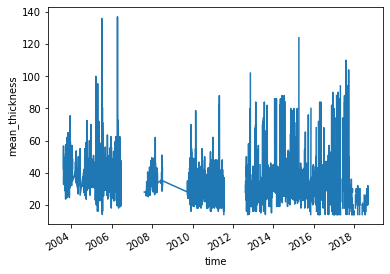

In [175]:
ds_A.mean_thickness.plot()

In [176]:
ds_A['year'] = xr.DataArray(pd.DatetimeIndex(ds_A.time.values).year,dims='time').assign_coords({"time":ds_A.time.values})

In [177]:
dsA = ds_A.swap_dims({'time':'year'})

In [178]:
m=['midnightblue','darkblue','mediumblue','blue','royalblue','dodgerblue','cyan','silver','gold','yellow','crimson','tomato','darksalmon','brown','firebrick','red']


In [199]:
dsA.groupby('year').mean().nb_steps

<xarray.DataArray 'nb_steps' (year: 16)>
array([4.35483871, 4.38461538, 4.23291925, 4.17105263, 3.82417582,
       3.97345133, 2.56097561, 2.17283951, 2.19680851, 2.43548387,
       2.36307692, 2.21604938, 2.50308642, 2.07763975, 0.36751269,
       0.09526262])
Coordinates:
  * year     (year) int64 2003 2004 2005 2006 2007 ... 2014 2015 2016 2017 2018

(0.0, 0.004)

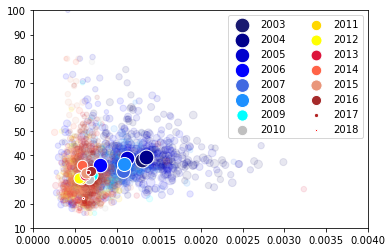

In [234]:
for i,y in enumerate(dsA.groupby('year').mean().year):
    data = dsA.sel(year=y.values)
    
    plt.scatter(x=data['mean_slope'],y=data['mean_thickness'],s=data['nb_steps']*10,alpha=0.1,c=m[i])

for i,y in enumerate(dsA.groupby('year').mean().year):    
    data_mean = dsA.groupby('year').mean().sel(year=y.values)    
    plt.scatter(x=data_mean['mean_slope'],y=data_mean['mean_thickness'],
                    s=data_mean['nb_steps']*50,c=m[i],edgecolors='white',label=str(y.values))
plt.legend(ncol=2);
plt.ylim(10,100);plt.xlim(0,4e-3)